In [281]:
#import all the necessary libraries
import requests
import json
import matplotlib.pyplot as plt
from rasterio.plot import show
import os
import pandas as pd
import plotly.graph_objects as go
import imageio
from glob import glob 
import os
from shapely.geometry.polygon import Polygon
from natsort import natsorted, ns
import rasterio
import rasterio.mask
import plotly.express as px
import time
import webbrowser
from mayavi import mlab
import mayavi
from IPython.display import Image


### Step 1: enter an address in Province Antwerp

In [282]:
#ask for input for an address in Antwerp
#Example format: Sint-Pietersvliet 7, 2000 Antwerpen
address=input("Please enter an address in Province Antwerp, format: street-name house-number postcode city")

In [283]:
# Log the start time
start_time = time.time()

### Step 2: find the address polygon data from API

In [284]:
#Parse the entered address
street_name = address.split(" ")[0]
house_number = address.split(" ")[-3]
postcode = address.split(" ")[-2]
name_of_the_municipality = address.split(" ")[-1]


#get the address information from api
address_url = "https://api.basisregisters.vlaanderen.be/v1/adresmatch"
address_params = {'straatnaam':street_name, 'huisnummer':house_number, 'postcode':postcode}
address_match_result = requests.get(address_url,params=address_params)
address_match_data = address_match_result.json()
address_match_data

{'adresMatches': [{'identificator': {'id': 'https://data.vlaanderen.be/id/adres/1410900',
    'naamruimte': 'https://data.vlaanderen.be/id/adres',
    'objectId': '1410900',
    'versieId': '2013-03-29T06:33:22+01:00'},
   'detail': 'https://api.basisregisters.vlaanderen.be/v1/adressen/1410900',
   'gemeente': {'objectId': '11002',
    'detail': 'https://api.basisregisters.vlaanderen.be/v1/gemeenten/11002',
    'gemeentenaam': {'geografischeNaam': {'spelling': 'Antwerpen',
      'taal': 'nl'}}},
   'postinfo': {'objectId': '2000',
    'detail': 'https://api.basisregisters.vlaanderen.be/v1/postinfo/2000'},
   'straatnaam': {'objectId': '2655',
    'detail': 'https://api.basisregisters.vlaanderen.be/v1/straatnamen/2655',
    'straatnaam': {'geografischeNaam': {'spelling': 'Sint-Pietersvliet',
      'taal': 'nl'}}},
   'huisnummer': '7',
   'volledigAdres': {'geografischeNaam': {'spelling': 'Sint-Pietersvliet 7, 2000 Antwerpen',
     'taal': 'nl'}},
   'adresPositie': {'point': {'coordina

In [285]:
#normalize the json data and find the gebouweenheden link
df=pd.json_normalize(address_match_data,'adresMatches')
gebouweenheden = df["adresseerbareObjecten"]
gebouweenheden_link = gebouweenheden[0][0]['detail']

In [286]:
#get the data from gebouweenheden
r = requests.get(gebouweenheden_link)
gebouwen_data = json.loads(r.content)
gebouwen_data 

{'identificator': {'id': 'https://data.vlaanderen.be/id/gebouweenheid/16689264',
  'naamruimte': 'https://data.vlaanderen.be/id/gebouweenheid',
  'objectId': '16689264',
  'versieId': '2016-02-04T06:36:31+01:00'},
 'geometriePunt': {'point': {'coordinates': [152242.43, 212849.5],
   'type': 'Point'}},
 'positieGeometrieMethode': 'afgeleidVanObject',
 'gebouweenheidStatus': 'gerealiseerd',
 'functie': 'gemeenschappelijkDeel',
 'gebouw': {'objectId': '16688047',
  'detail': 'https://api.basisregisters.vlaanderen.be/v1/gebouwen/16688047'},
 'adressen': [{'objectId': '1410900',
   'detail': 'https://api.basisregisters.vlaanderen.be/v1/adressen/1410900'}]}

In [287]:
#extract gebouw link from the dictionary of gebouwenheden
gebouw_link = gebouwen_data['gebouw']['detail']
print(gebouw_link)

https://api.basisregisters.vlaanderen.be/v1/gebouwen/16688047


In [288]:
#extract polygon data from the dictionary of gebouwenheden
r = requests.get(gebouw_link)
gebouw_data = json.loads(r.content)
polygon = Polygon(gebouw_data['geometriePolygoon']['polygon']['coordinates'][0])
polygon_coord = gebouw_data['geometriePolygoon']['polygon']['coordinates'][0]


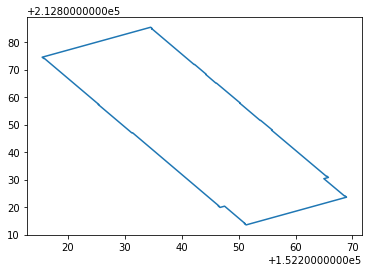

In [289]:
#plot the polygon of the address 
coord=polygon_coord
xs, ys = zip(*coord) #create lists of x and y values
plt.figure()
plt.plot(xs,ys) 
plt.show() 

### Step 3: Get the list of all the tif file of DSM and DTM

In [290]:
dtm_path = '/Users/yihuiwang/Documents/BeCode/My_project/3D_House/3d house data/DTM/**/*.tif'
dsm_path = '/Users/yihuiwang/Documents/BeCode/My_project/3D_House/3d house data/DSM/**/*.tif'
def tif_file(path):
    
    tif_file =[]
    
    # using glob library to get all the file with .tif
    files = glob(path,recursive = True) 
    for file in files: 
        tif_file.append(file)

     # sort files with number in the file (ascending order) using natsorted library
    tif_file = natsorted(tif_file, alg=ns.IGNORECASE)     
    return tif_file

dsm_tif= tif_file(dsm_path)
#print(dsm_tif)

In [291]:
dtm_tif= tif_file(dtm_path)
#print(dtm_tif)

### Step 4: Creat bounding box of all the downloaded zone

In [292]:
for file in dsm_tif:
     dsm_bounds = rasterio.open(file).bounds
     #print(dsm_bounds)

### Step 5: Find in which zone the given address is located    
        (if not an address in Province Antwerp, ask to enter a new address)

In [293]:
# to check which dsm tif contains the polygon of the given address

def check_polygon_in_dsm():
    for file in dsm_tif:
        bound = rasterio.open(file).bounds
        for x, y in polygon_coord:
            if (bound[0]<= x <= bound[2]) and (bound[1]<= y <= bound[3]):
                    scr_path=file
                    print('The house is in this tif:',file)
                    return scr_path
            else:
                pass
    print("This address is not in Province Antwerp. Please enter a new address.")
            

dsm_src_path = check_polygon_in_dsm()


The house is in this tif: /Users/yihuiwang/Documents/BeCode/My_project/3D_House/3d house data/DSM/DHMVIIDSMRAS1m_k15/GeoTIFF/DHMVIIDSMRAS1m_k15.tif


In [294]:
# to check which dtm tif contains the polygon of the given address

def check_polygon_in_dtm():
    for file in dtm_tif:
        bound = rasterio.open(file).bounds
        for x, y in polygon_coord:
            if (bound[0]<= x <= bound[2]) and (bound[1]<= y <= bound[3]):
                    scr_path=file
                    print('The house is in this tif:',file)
                    return scr_path
            else:
                pass
    print("This address is not in Province Antwerp. Please enter a new address.")
            

dtm_src_path = check_polygon_in_dtm()

The house is in this tif: /Users/yihuiwang/Documents/BeCode/My_project/3D_House/3d house data/DTM/DHMVIIDTMRAS1m_k15/GeoTIFF/DHMVIIDTMRAS1m_k15.tif


In [295]:
print(dsm_src_path)
print(dtm_src_path)


/Users/yihuiwang/Documents/BeCode/My_project/3D_House/3d house data/DSM/DHMVIIDSMRAS1m_k15/GeoTIFF/DHMVIIDSMRAS1m_k15.tif
/Users/yihuiwang/Documents/BeCode/My_project/3D_House/3d house data/DTM/DHMVIIDTMRAS1m_k15/GeoTIFF/DHMVIIDTMRAS1m_k15.tif


### Step 6: clip the dsm and dtm based on the polygon of address

In [296]:
#creat a function to clip dsm and dtm
def clip(path):
    try:
        with rasterio.open(path) as src:
            out_image, out_transform = rasterio.mask.mask(src, [polygon], crop=True)
        clipped_result = out_image[0]
    except Exception as err:
        print("Problem with clipping process")
        
    return clipped_result

clipped_dsm = clip(dsm_src_path)
clipped_dtm = clip(dtm_src_path)

### Step 7: calculate the CHM of the address

In [297]:
clipped_chm = clipped_dsm-clipped_dtm

### Step 8: 3D plot of the house

In [298]:
fig= go.Figure(data = [go.Surface(z=clipped_chm)])
fig.update_layout(title= address, autosize=False,
                  width=700, height=700,
                  margin=dict(l=70, r=70, b=70, t=90))
fig.update_scenes(xaxis_title_text='Distance (m)',  
                  yaxis_title_text='Distance (m)',  
                  zaxis_title_text='Elevation (m)')
fig.show()

In [299]:
# Log the end time
end_time = time.time()

print('Time taken for generating 3D house in seconds: ', end_time - start_time)

Time taken for generating 3D house in seconds:  5.0610129833221436


In [300]:
#save the 3d image into html
saving_path = "/Users/yihuiwang/Documents/BeCode/My_project/3D_House/3d house data/3d_effect/"
fig.write_html(saving_path+address+'.html')


In [301]:
mlab.figure(size=(640, 800), bgcolor=(0.16, 0.28, 0.46))

surf = mlab.surf(clipped_chm)
mayavi.mlab.title(address)

saving_path = "/Users/yihuiwang/Documents/BeCode/My_project/3D_House/3d house data/3d_effect/"
mlab.savefig(saving_path+address+'.png')
# show saved mayavi image
mlab.show()
mayavi.mlab.close(all=True)

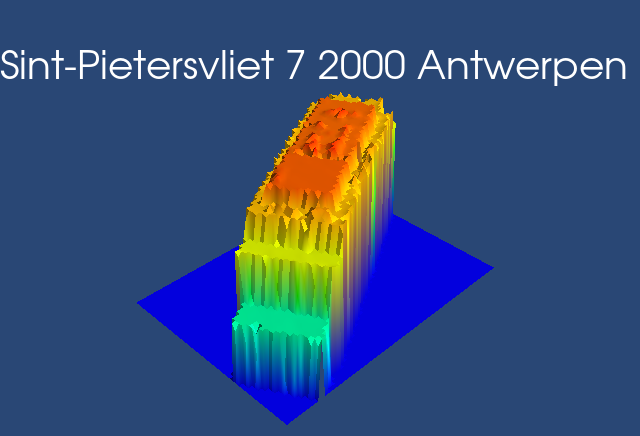

In [302]:
Image(saving_path+address+'.png')

### Step 9: check the 3d house with the google street view

In [303]:
# to view actual house on google map
url = 'https://www.google.com/maps/place/'+str(street_name)+'+'+house_number+',+'+postcode+'+'+name_of_the_municipality
webbrowser.open(url)


True